# **Trabajo Final Valoración de Derivados**

### Integrantes
Esteban Zuluaga

Miguel Gallón

Isabella García

Esteban Gómez 

In [1]:
import pandas as pd
import gurobipy as gp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as si
import yfinance as yf

In [2]:
# Hay que entrar el sigma al cuadrado! Osea se entra la varianza!
def black_scholes(S, K, T, r_loc,r_ext, sigma, option_type='call'):
  
    # Calculate d1 and d2
    d1 = (np.log(S / K) + ((r_loc-r_ext) + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + ((r_loc-r_ext) - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        option_price = (S*np.exp(-r_ext * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r_loc * T) * si.norm.cdf(d2, 0.0, 1.0))
    elif option_type == 'put':
        option_price = (K * np.exp(-r_loc * T) * si.norm.cdf(-d2, 0.0, 1.0) - S *np.exp(-r_ext * T)* si.norm.cdf(-d1, 0.0, 1.0))
    else:
        raise ValueError("Option type must be 'call' or 'put'")
    
    return option_price

# Datos Iniciales

## Datos

In [3]:
data= yf.download(tickers="COP=X",start="2019-05-23", end="2024-05-23")
precios= data["Adj Close"].copy()
precios =pd.DataFrame(precios)
rendimientos=precios.apply(lambda x: np.log(x).diff())

[*********************100%%**********************]  1 of 1 completed


In [4]:
Spot_P= data["Adj Close"].iloc[-1]
Strike= 3800 # Strike más cercano a ATM
t_1= 33/365 # Vencimiento de la opción más cercana a vencer
r_local= np.log(1+0.10963) #ACC
r_extranjera= 0.0531 #ACC
Sigma_Rend= np.std(rendimientos,axis=0) * np.sqrt(252)
Sigma_Rend=float(Sigma_Rend.iloc[0])

In [26]:
Sigma_Rend

0.15965970263134174

**Strike** fue escogido de manera estrategica con las persepctiva  de la tasa  de cambio y del precio spot, para cualquier tipo de opción, si el objetivo es la cobertura, se debe escoger el precio spot como el strike (Opción ATM)

**R_Local**: La tasa local se obtuvo la IBR Overnight del Banco de la Republica, que se ubicó el 05/24/2024 en 10.963%

**R_Extranjera**: Para la escogencia de la tasa extranjera se escogio la tasa SOFR overnight, la cual para el 05/24/2024 se situaba  en 5.31%

**Segima_Rend**: Para la volatilidad implícita se optó por encontrar la desviación estándar de los retornos diarios y anualizarla.

In [5]:
put_price = black_scholes(S=Spot_P, K=Strike, T=t_1,r_loc=r_local ,r_ext= r_extranjera, sigma=Sigma_Rend, option_type='put')
put_price

54.89798285265374

# Optimización

In [6]:
def optimizacion(Aversion_R, K, p_0, mu_S,sigma_p,S_0):
    m= gp.Model()
    eta= m.addVar(lb= -1*float("inf") )
    pi = (mu_S-S_0)+eta*(K-mu_S-p_0) - Aversion_R*sigma_p*(1+ eta**2 - 2*eta)
    m.setObjective(-1*pi)
    m.optimize()
    n_options= eta.x
    return n_options

In [7]:
Mu_USDCOP= np.mean(data["Adj Close"])
Sigma_Precios= np.var(data["Adj Close"])
Coef_Aversion_Riesgo= 1
Razon_Cobertura= optimizacion(Aversion_R=Coef_Aversion_Riesgo,K=Strike,p_0=put_price,mu_S=Mu_USDCOP,sigma_p=Sigma_Precios, S_0=Spot_P)

Restricted license - for non-production use only - expires 2025-11-24
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 1 columns and 0 nonzeros
Model fingerprint: 0x23637c54
Model has 1 quadratic objective term
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e+05, 4e+05]
  QObjective range [4e+05, 4e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective 7.59181679e+01


In [8]:
print(f"La razón de cobertura de la fórmula empleada, para un agente con un coeficiente de aversión al riesgo de 1 es de: {Razon_Cobertura:.4f}")

La razón de cobertura de la fórmula empleada, para un agente con un coeficiente de aversión al riesgo de 1 es de: 0.9995


## Gráfica de los diferentes Payoffs

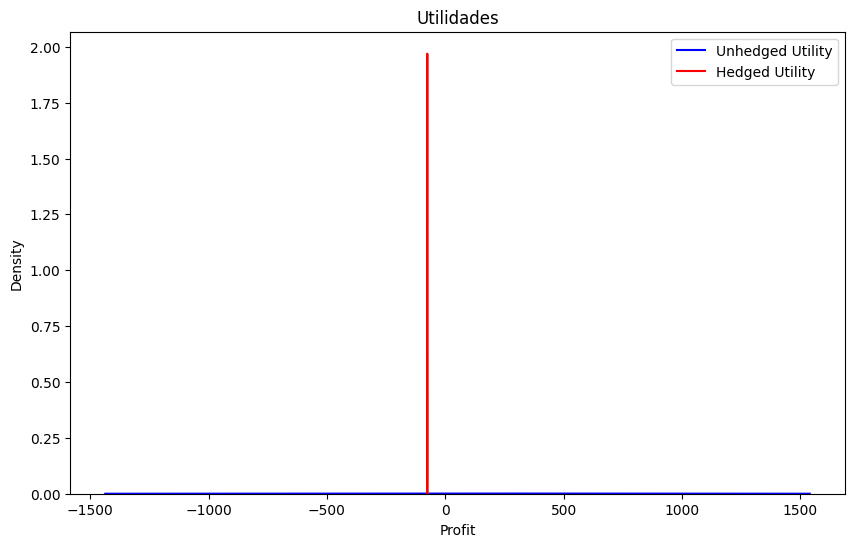

In [9]:
Prices = np.random.normal(loc=Mu_USDCOP,scale=np.sqrt(Sigma_Precios),size=1000)
Unhedged_utility=(Prices-Spot_P)
Hedged_utility= (Prices-Spot_P)+Razon_Cobertura*(Strike-Prices-put_price)
plt.figure(figsize=(10, 6))
sns.kdeplot(Unhedged_utility, fill=False, color='b',label='Unhedged Utility')
sns.kdeplot(Hedged_utility, fill=False, color='r', label='Hedged Utility')

plt.title('Utilidades')
plt.xlabel('Profit')
plt.ylabel('Density')
plt.legend()
plt.show()

### Estadísticas Descriptivas

In [10]:
Unhedged_utility_df= pd.DataFrame(Unhedged_utility)
Hedged_utility_df= pd.DataFrame(Hedged_utility)
Megerd_Df= pd.merge(Unhedged_utility_df,Hedged_utility_df,left_index=True,right_index=True)
Megerd_Df=Megerd_Df.rename(columns={"0_x":"Unhedged Utility","0_y":"Hedged Utility"})
Megerd_Df.describe()

,Unhedged Utility,Hedged Utility
count,1000.000000,1000.000000
mean,105.223337,-75.871881
std,412.595087,0.196208
min,-1125.676694,-76.457232
25%,-179.370823,-76.007219
50%,102.743652,-75.873060
75%,399.221201,-75.732071
max,1229.318588,-75.337321


## Gráfica de diferentes aversiones al riesgo

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 1 columns and 0 nonzeros
Model fingerprint: 0x665843dd
Model has 1 quadratic objective term
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [2e+05, 2e+05]
  QObjective range [2e+05, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective 7.58782943e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to

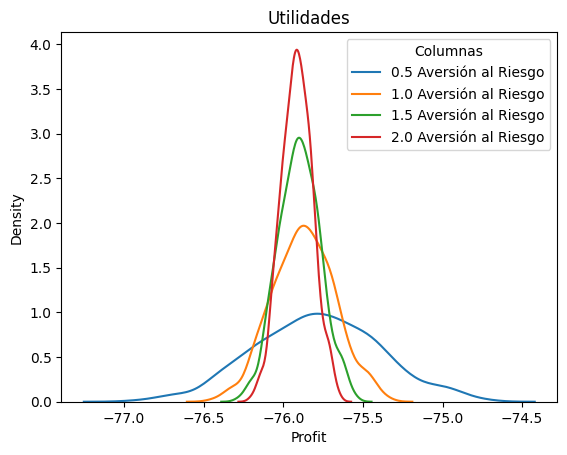

In [11]:
Risk_Adversion_Line= [0.5,1,1.5,2]
Risk_Adversion_Utility_df= pd.DataFrame()


for i in Risk_Adversion_Line:
    Razon_Cobertura= optimizacion(Aversion_R=i,K=Strike,p_0=put_price,mu_S=Mu_USDCOP,sigma_p=Sigma_Precios, S_0=Spot_P)
    Hedged_utility= (Prices-Spot_P)+Razon_Cobertura*(Strike-Prices-put_price)
    Risk_Adversion_Utility_df[i]= Hedged_utility
for column in Risk_Adversion_Utility_df.columns:
    sns.kdeplot(Risk_Adversion_Utility_df[column], fill=False, label=f"{column} Aversión al Riesgo")

# Añadir título y etiquetas
plt.title('Utilidades')
plt.xlabel('Profit')
plt.ylabel('Density')

# Añadir la leyenda
plt.legend(title='Columnas')

# Mostrar el gráfico
plt.show()

### Estadísticas Descriptivas

In [12]:
Risk_Adversion_Utility_df.describe()

,0.5,1.0,1.5,2.0
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-75.785721,-75.871881,-75.900601,-75.914961
std,0.392417,0.196208,0.130806,0.098104
min,-76.956423,-76.457232,-76.290835,-76.207637
25%,-76.056397,-76.007219,-75.990827,-75.982630
50%,-75.788079,-75.873060,-75.901387,-75.915551
75%,-75.506101,-75.732071,-75.807395,-75.845056
max,-74.716600,-75.337321,-75.544228,-75.647681


## Graficas de diferentes Strikes

In [13]:
Strikes_Line= [3000,3200,3500,3800,4000,4200]
Strikes_Utility_df= pd.DataFrame()
for i in Strikes_Line:
    put_price1 = black_scholes(S=Spot_P, K=i, T=t_1,r_loc=r_local ,r_ext= r_extranjera, sigma=Sigma_Rend, option_type='put')
    Razon_Cobertura1= optimizacion(Aversion_R=Coef_Aversion_Riesgo,K=i,p_0=put_price1,mu_S=Mu_USDCOP,sigma_p=Sigma_Precios, S_0=Spot_P)
    Hedged_utility1= (Prices-Spot_P)+Razon_Cobertura1*(i-Prices-put_price1)
    Strikes_Utility_df[i]= Hedged_utility1

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 1 columns and 0 nonzeros
Model fingerprint: 0x1ac577ad
Model has 1 quadratic objective term
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e+05, 4e+05]
  QObjective range [4e+05, 4e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective 8.19878679e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to

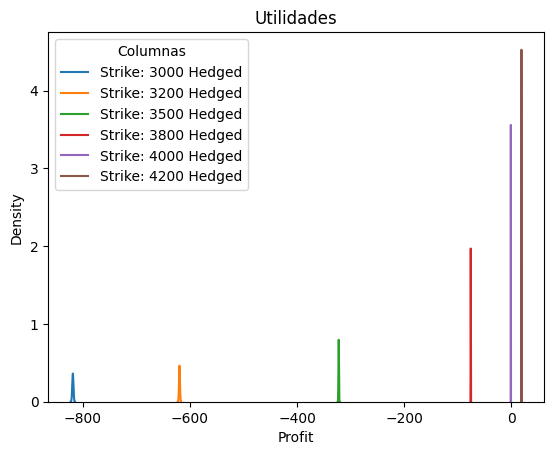

In [14]:
for column in Strikes_Utility_df.columns:
    sns.kdeplot(Strikes_Utility_df[column], fill=False, label=f"Strike: {column} Hedged")
#sns.kdeplot(Unhedged_utility, fill=False, color='black',label='Unhedged Utility')
# Añadir título y etiquetas
plt.title('Utilidades')
plt.xlabel('Profit')
plt.ylabel('Density')

# Añadir la leyenda
plt.legend(title='Columnas')

# Mostrar el gráfico
plt.show()

# Valorar Cobertura Futuro (Punto 5)

In [15]:
Precio_Futuro=Spot_P*np.exp((r_local-r_extranjera)*t_1)
Precio_Futuro


3838.694026547465

In [16]:
def optimizacion_F(Aversion_R, S_Futuro, mu_S,sigma_p,S_0):
    m= gp.Model()
    eta= m.addVar(lb= -1*float("inf") )
    pi = (mu_S-S_0)+eta*(S_Futuro-mu_S) - Aversion_R*sigma_p*(1+ eta**2 - 2*eta)
    m.setObjective(-1*pi)
    m.optimize()
    n_options= eta.x
    return n_options

In [17]:
Razon_Cobertura_F= optimizacion_F(Aversion_R=Coef_Aversion_Riesgo,S_Futuro=Precio_Futuro,mu_S=Mu_USDCOP,sigma_p=Sigma_Precios, S_0=Spot_P)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 1 columns and 0 nonzeros
Model fingerprint: 0x0380b046
Model has 1 quadratic objective term
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e+05, 4e+05]
  QObjective range [4e+05, 4e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.76417541e+01


In [18]:
print(f"La razón de cobertura de la fórmula empleada, para un agente con un coeficiente de aversión al riesgo de 1 es de: {Razon_Cobertura_F:.4f}")

La razón de cobertura de la fórmula empleada, para un agente con un coeficiente de aversión al riesgo de 1 es de: 0.9998


## Gráficos Utilidad Cobertura vs No Cobertura (Futuros)

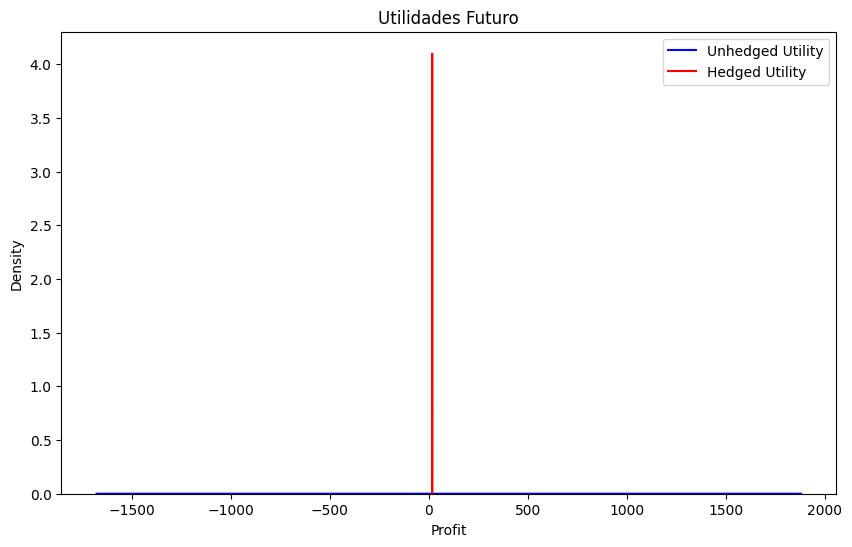

In [21]:
Prices = np.random.normal(loc=Mu_USDCOP,scale=np.sqrt(Sigma_Precios),size=1000)
Unhedged_utility_F=(Prices-Spot_P)
Hedged_utility_F= (Prices-Spot_P)+Razon_Cobertura*(Precio_Futuro-Prices)
plt.figure(figsize=(10, 6))
sns.kdeplot(Unhedged_utility_F, fill=False, color='b',label='Unhedged Utility')
sns.kdeplot(Hedged_utility_F, fill=False, color='r', label='Hedged Utility')

plt.title('Utilidades Futuro')
plt.xlabel('Profit')
plt.ylabel('Density')
plt.legend()
plt.show()

In [1]:
print("Hola")

Hola


### Estadísticas Descriptivas

In [22]:
Unhedged_utility_F_df= pd.DataFrame(Unhedged_utility_F)
Hedged_utility_F_df= pd.DataFrame(Hedged_utility_F)
Megerd_Df= pd.merge(Unhedged_utility_F_df,Hedged_utility_F_df,left_index=True,right_index=True)
Megerd_Df=Megerd_Df.rename(columns={"0_x":"Unhedged Utility","0_y":"Hedged Utility"})
Megerd_Df.describe()

,Unhedged Utility,Hedged Utility
count,1000.000000,1000.000000
mean,112.290247,17.656475
std,409.772417,0.097433
min,-1367.923870,17.304519
25%,-157.830631,17.592247
50%,112.080921,17.656425
75%,376.953429,17.719405
max,1570.749995,18.003258


## Gráfico diferente aversión al riesgo (Futuros)

In [23]:
Risk_Adversion_Line= [0.5,1,1.5,2]
Risk_Adversion_Utility_F_df= pd.DataFrame()
for i in Risk_Adversion_Line:
    Razon_Cobertura= optimizacion_F(Aversion_R=i,S_Futuro=Precio_Futuro,mu_S=Mu_USDCOP,sigma_p=Sigma_Precios, S_0=Spot_P)
    Hedged_utility= (Prices-Spot_P)+Razon_Cobertura*(Precio_Futuro-Prices)
    Risk_Adversion_Utility_F_df[i]= Hedged_utility

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 1 columns and 0 nonzeros
Model fingerprint: 0xbeb36edc
Model has 1 quadratic objective term
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [2e+05, 2e+05]
  QObjective range [2e+05, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.76495402e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up t

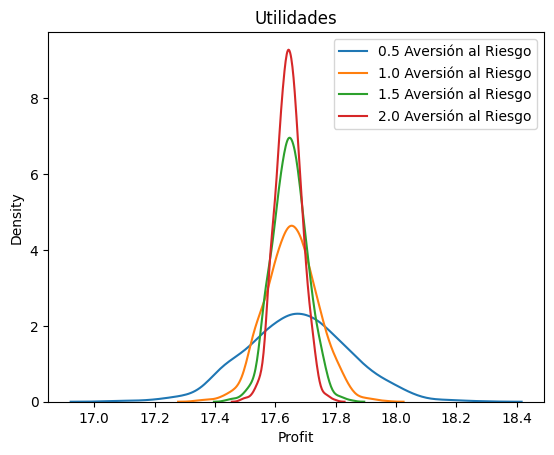

In [24]:
for column in Risk_Adversion_Utility_F_df.columns:
    sns.kdeplot(Risk_Adversion_Utility_F_df[column], fill=False, label=f"{column} Aversión al Riesgo")

# Añadir título y etiquetas
plt.title('Utilidades')
plt.xlabel('Profit')
plt.ylabel('Density')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

### Estadísticas Descriptivas

In [25]:
Risk_Adversion_Utility_F_df.describe()

,0.5,1.0,1.5,2.0
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,17.673750,17.653859,17.647229,17.643914
std,0.172220,0.086110,0.057407,0.043055
min,17.051642,17.342805,17.439859,17.488387
25%,17.560223,17.597096,17.609386,17.615532
50%,17.673662,17.653815,17.647199,17.643892
75%,17.784984,17.709476,17.684306,17.671722
max,18.286715,17.960342,17.851550,17.797155
